In [138]:
# Import

# Basic
from time import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



---
# My Plan

My ultimate objective is to predict the probability of credit card defaults. My plan is to develop a classification algorithm, to predict if a user is going to default. Then, I can predict the probability of default based on the number of predicted default users.

1. Load data and check columns
2. Calculate the percentage of credit card defaults out of all the users
3. Explore the whole dataset and find any interesting insights. At the same time, 
    - evaluate the data quality 
    - figure out whether outliers exist
    - Clean Data
4. Perform feature engineering
5. Quick fit and Select the strongest predictors



---
# 1. Loading Credit Card User Data

In [4]:
# Load the data
df = pd.read_csv('dataset/data.csv') 
df.dtypes


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
PAY_1                         float64
dtype: objec

---

PAY_1 is not in the data dictionary. Let's see whats in it.

In [5]:
df.PAY_1

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
9995   NaN
9996   NaN
9997   NaN
9998   NaN
9999   NaN
Name: PAY_1, Length: 10000, dtype: float64

Looks like its all missing values. Let's do a quick check.

In [6]:
df.groupby(df.PAY_1.astype(str)).agg({'ID':'count'})

,ID
PAY_1,
0.0,100
nan,9900


Yes, almost all of it are missing values. 100 of them are labelled as 0 but 0 has not be defined in the data dictionary. So, there is no meaningful data in this column.

Therefore, I have decided to remove PAY_1.



In [7]:
df.drop(columns=['PAY_1'], inplace=True)
df.dtypes


ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

---
On the other hand, according to the dictionary, PAY_0 is the Repayment status in September, which is inconsistent with the labelling of BILL_AMT1 (September) and PAY_AMT1 (September). Therefore, I believe 'PAY_0' was a mislabelled. I will rename it as PAY_1.

In [8]:
# fixing the names
df = df.rename(columns={'PAY_0': 'PAY_1'})
df.dtypes



ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_1                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

---
I found the field name 'default.payment.next.month' not easy to use. Therefore, I am going to rename it as 'DEFAULT_PAY'.


In [9]:
# fixing the names
df = df.rename(columns={'default.payment.next.month': 'DEFAULT_PAY'})
df.dtypes


ID               int64
LIMIT_BAL      float64
SEX              int64
EDUCATION        int64
MARRIAGE         int64
AGE              int64
PAY_1            int64
PAY_2            int64
PAY_3            int64
PAY_4            int64
PAY_5            int64
PAY_6            int64
BILL_AMT1      float64
BILL_AMT2      float64
BILL_AMT3      float64
BILL_AMT4      float64
BILL_AMT5      float64
BILL_AMT6      float64
PAY_AMT1       float64
PAY_AMT2       float64
PAY_AMT3       float64
PAY_AMT4       float64
PAY_AMT5       float64
PAY_AMT6       float64
DEFAULT_PAY      int64
dtype: object

---
# 2. Calculate the percentage of credit card defaults out of all the users


In [10]:
df.DEFAULT_PAY.sum() / len(df.DEFAULT_PAY)


0.2238

22% of credit card user have defaulted. 

In mentioned earlier, I have to develop a classification algorithm. However, given this uneven class distribution (78% vs 22%), we have to be careful when choosing our evaluation metric. F1 is, in my knowledge, the best candidate.



---
# 3. Explore the whole dataset and find any interesting insights


In [11]:
# create a copy of df so that I could improve the labelling of categories. 
df_explore = df.copy()

---
## 3.1. Categorical data
There are Sex, Education and Marriage.


---
### Sex
Key: 1=male, 2=female


In [12]:
# relabel
df_explore['SEX'] = df_explore['SEX'].replace([1,2],['male','female'])


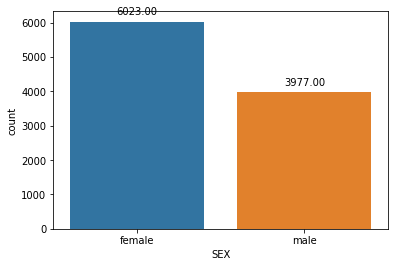

In [13]:
def bar_chart(df, col):
    ax = sns.countplot(x=col, data=df)
    
    for p in ax.patches:
        ax.annotate(\
            format(p.get_height(), '.2f'), \
            (p.get_x() + p.get_width() / 2., p.get_height()), \
            ha = 'center', va = 'center', \
            xytext = (0, 10), \
            textcoords = 'offset points')

bar_chart(df_explore, 'SEX')

    

In [14]:
def d_rate_by_col(df, col):
    d_rate = df.groupby([col, 'DEFAULT_PAY']).size().unstack()
    d_rate['perc'] = \
        (d_rate[d_rate.columns[1]]/(d_rate[d_rate.columns[0]] + d_rate[d_rate.columns[1]]))
    return d_rate

d_rate_by_col(df_explore, 'SEX')

DEFAULT_PAY,0,1,perc
SEX,,,
female,4723,1300,0.215839
male,3039,938,0.235856


There are more female than male.

Male are more likely to default than Female. 


---
### Education
Key: 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown


In [15]:
df_explore.groupby(df_explore.EDUCATION.astype(str)).agg({'ID':'count'})



,ID
EDUCATION,
0,8
1,3514
2,4585
3,1633
4,46
5,90
6,124


0 has not been defined in the data dictionary. So, I am going to group it together with 5 and 6 (both unknown).

In addition, 4 only has 46 samples. It is not going to be a strong predictor anyway so I am going to merge it with the unknown group.

In [16]:
# relabel and re-group
df_explore['EDUCATION'] = \
    df_explore['EDUCATION'].replace([0,4,5,6],'unknown_and_others')
df_explore['EDUCATION'] = df_explore['EDUCATION'].replace([1,2,3],['graduate_school','university','high_school'])


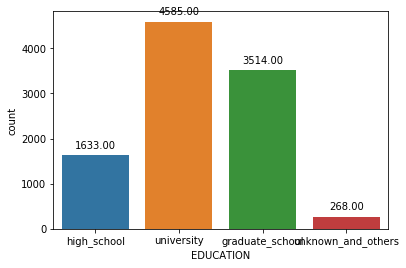

In [17]:
bar_chart(df_explore, 'EDUCATION')

In [18]:
d_rate_by_col(df_explore, 'EDUCATION')

DEFAULT_PAY,0,1,perc
EDUCATION,,,
graduate_school,2819,695,0.197780
high_school,1223,410,0.251072
university,3465,1120,0.244275
unknown_and_others,255,13,0.048507


Most users are university students. The second biggest group is graduate students.

It seems like the higher the education level (high school < university < graduate school) the lower the default rate.  


---

### Marriage
Key: 1=married, 2=single, 3=others

In [19]:
df_explore.groupby(df_explore.MARRIAGE.astype(str)).agg({'ID':'count'})


,ID
MARRIAGE,
0,13
1,4476
2,5287
3,224


0 has not been defined in the data dictionary. It only has 13 samples. So, I am going to group it with 3 (others).


In [20]:
# relabel and re-group
df_explore['MARRIAGE'] = \
    df_explore['MARRIAGE'].replace([0,3],'unknown_and_others')
df_explore['MARRIAGE'] = df_explore['MARRIAGE'].replace([1,2],['married','single'])


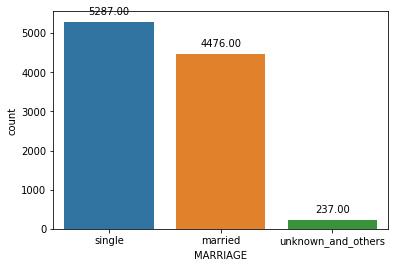

In [21]:
bar_chart(df_explore, 'MARRIAGE')

In [22]:
d_rate_by_col(df_explore, 'MARRIAGE')

DEFAULT_PAY,0,1,perc
MARRIAGE,,,
married,3393,1083,0.241957
single,4175,1112,0.210327
unknown_and_others,194,43,0.181435


Most users are single. 

Married users have higher default rate.


---

## 3.1. Continuous data
There are 
- Credit, 
- Age, 
- Repayment status in month X, 
- Amount of bill statement in month X,
- Amount of previous payment in month X.

---

### Credit


No handles with labels found to put in legend.


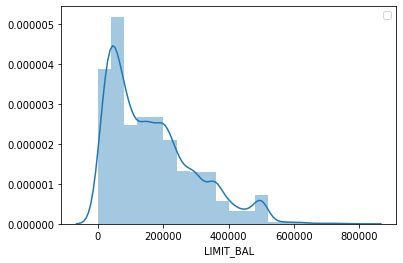

In [191]:
sns.distplot( df_explore['LIMIT_BAL'], bins=20)
plt.legend()



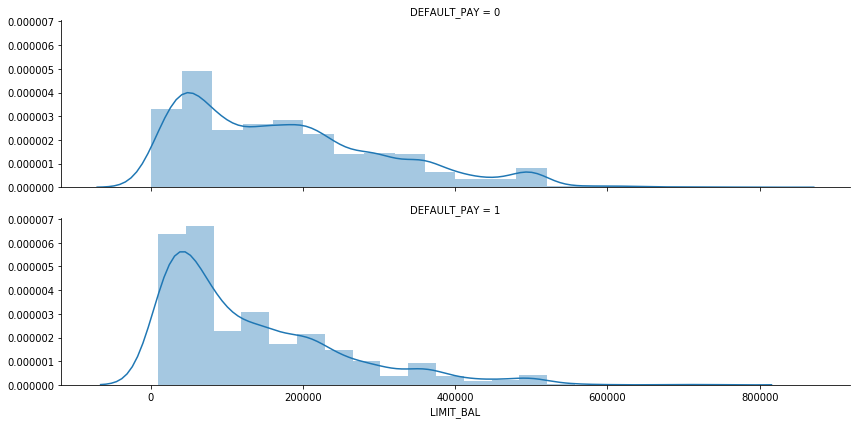

In [196]:
def def_dist(df, col, bins):
    g = sns.FacetGrid(df, row='DEFAULT_PAY',
                  height=3, aspect=4,)
    g.map(sns.distplot, col, bins=bins);

def_dist(df_explore, 'LIMIT_BAL', 20)



The distribution of credit is skewed, with a long tail of high credit users.

As expected, the most defaulted users have lower credits.

---

### Age


No handles with labels found to put in legend.


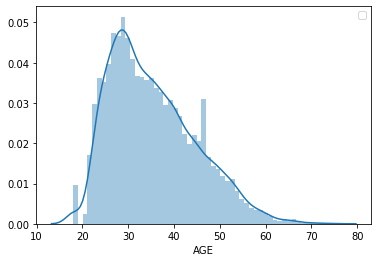

In [213]:
sns.distplot( df_explore['AGE'], bins=55)
plt.legend()


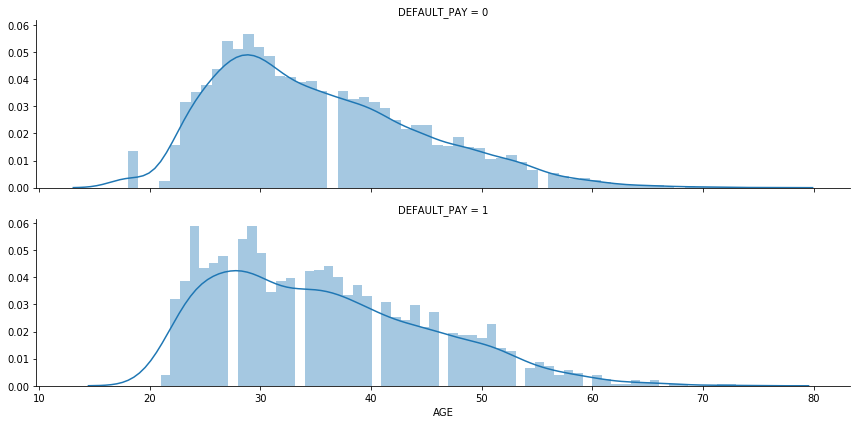

In [217]:
def_dist(df_explore, 'AGE', 60)



The distribution of age is skewed, with a long tail of older users.


---

### Understanding the relationship among Bill, Payment and Repayment Status
- BILL_AMT: Amount of bill statement in XXXX
- PAY_AMT: Amount of previous payment in XXXX
- PAY: Repayment status in XXXX, (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

To understand the relationship among the factors, I have selected the items with repayment status = pay duly (i.e. -1).  


In [27]:
sel_filter = ((df.PAY_6 == -1) & (df.BILL_AMT6 > 0))
df_explore[sel_filter][['BILL_AMT6', 'PAY_AMT6', 'PAY_6', 'BILL_AMT5', 'PAY_AMT5', 'PAY_5']].sample(10)

,BILL_AMT6,PAY_AMT6,PAY_6,BILL_AMT5,PAY_AMT5,PAY_5
4818,4012.0,0.0,-1,0.0,4012.0,-2
2042,4066.0,2476.0,-1,1717.0,4086.0,-1
6477,7485.0,10254.0,-1,4716.0,7485.0,-1
8302,3204.0,4173.0,-1,2811.0,3204.0,-1
6050,7190.0,0.0,-1,5381.0,7190.0,0
9074,1332.0,2444.0,-1,1313.0,1332.0,-1
9451,2941.0,291.0,-1,951.0,2941.0,-1
7207,823.0,4507.0,-1,10898.0,840.0,0
4091,843.0,22000.0,-1,1714.0,1000.0,0
471,1989.0,3370.0,-1,1806.0,1989.0,-1


In [28]:
df_explore[sel_filter].groupby(df_explore.BILL_AMT6<=df_explore.PAY_AMT5).agg({'ID':'count'})


,ID
False,41
True,1670


In [29]:
sel_filter = ((df.PAY_5 == -1) & (df.BILL_AMT5 > 0))
df_explore[sel_filter][['BILL_AMT5', 'PAY_AMT5', 'PAY_5', 'BILL_AMT4', 'PAY_AMT4', 'PAY_4']].sample(10)

,BILL_AMT5,PAY_AMT5,PAY_5,BILL_AMT4,PAY_AMT4,PAY_4
2331,62063.0,14122.0,-1,81414.0,62063.0,-1
4032,10122.0,2697.0,-1,6150.0,10152.0,0
9507,420.0,1572.0,-1,711.0,420.0,-1
7732,4392.0,9493.0,-1,4387.0,4392.0,-1
1226,4935.0,3000.0,-1,17849.0,4935.0,0
7325,8000.0,0.0,-1,0.0,8000.0,-1
8802,9917.0,33826.0,-1,17252.0,9965.0,-1
8276,13716.0,7100.0,-1,2481.0,13716.0,-1
628,2119.0,0.0,-1,0.0,2119.0,-1
1798,316.0,316.0,-1,316.0,316.0,-1


In [30]:
df_explore[sel_filter].groupby(df_explore.BILL_AMT5<=df_explore.PAY_AMT4).agg({'ID':'count'})


,ID
False,33
True,1635


I can see that PAY_AMT(n) is related to BILL_AMT(n+1).



---
###  Repayment status: PAY_(n) 

Key: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above

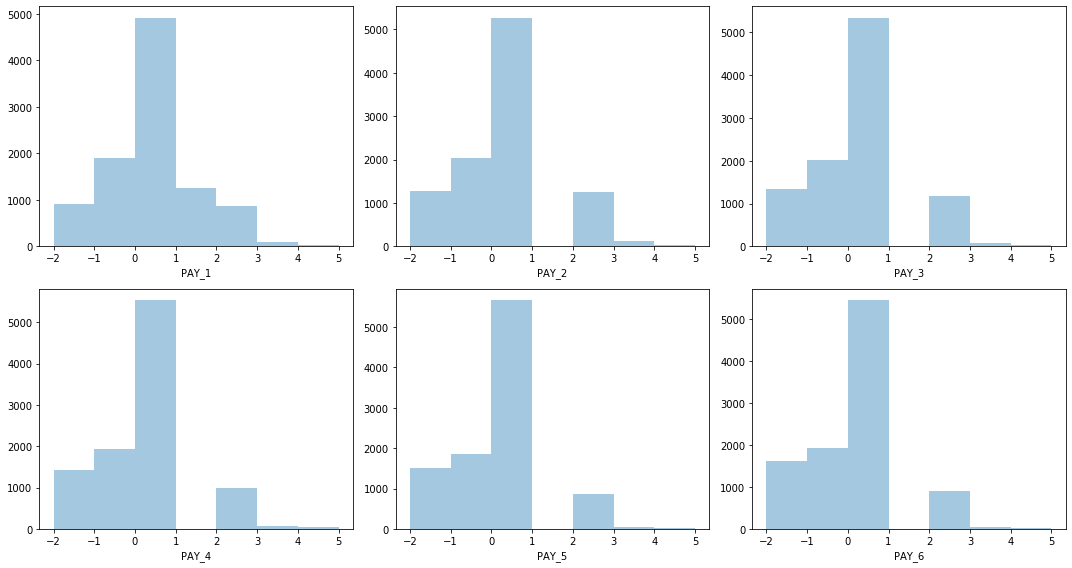

In [31]:
# plot the histogram of the payment
fig, axes = plt.subplots(2,3,figsize=(15,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    plt.subplot(ax)
    sns.distplot(df_explore['PAY_'+str(i+1)], bins=np.arange(-2,6), kde=False, ax=ax)
    ax.set(xlabel='PAY_'+str(i+1))

plt.tight_layout()



- Unknown: -2 and 0 are not documented in the data dictionary. Therefore, I am going to group them into 'unknown'.

- Delayed: There isn't much variation in the number of delay months, most of the months has 2 months delays. Therefore, I am going to group all 1+ month delays as 'delay'.

- Pay duly: -1 (no change).


In [32]:
select_cols = ['PAY_'+str(i) for i in range(1,7)]
df_explore[select_cols] = df_explore[select_cols].replace([-2,0],'unknown')
df_explore[select_cols] = df_explore[select_cols].replace(np.arange(1,10),'delayed')
df_explore[select_cols] = df_explore[select_cols].replace(-1,'pay_duly')



In [33]:
d_rate_by_col(df_explore, 'PAY_1')


DEFAULT_PAY,0,1,perc
PAY_1,,,
delayed,1126,1152,0.505707
pay_duly,1596,302,0.159115
unknown,5040,784,0.134615


In [34]:
d_rate_by_col(df_explore, 'PAY_2')


DEFAULT_PAY,0,1,perc
PAY_2,,,
delayed,644,790,0.550907
pay_duly,1715,318,0.156419
unknown,5403,1130,0.172968


As expected, the users with delayed payments are more likely to default.


---
### Amount of bill statement: BILL_AMT(n)


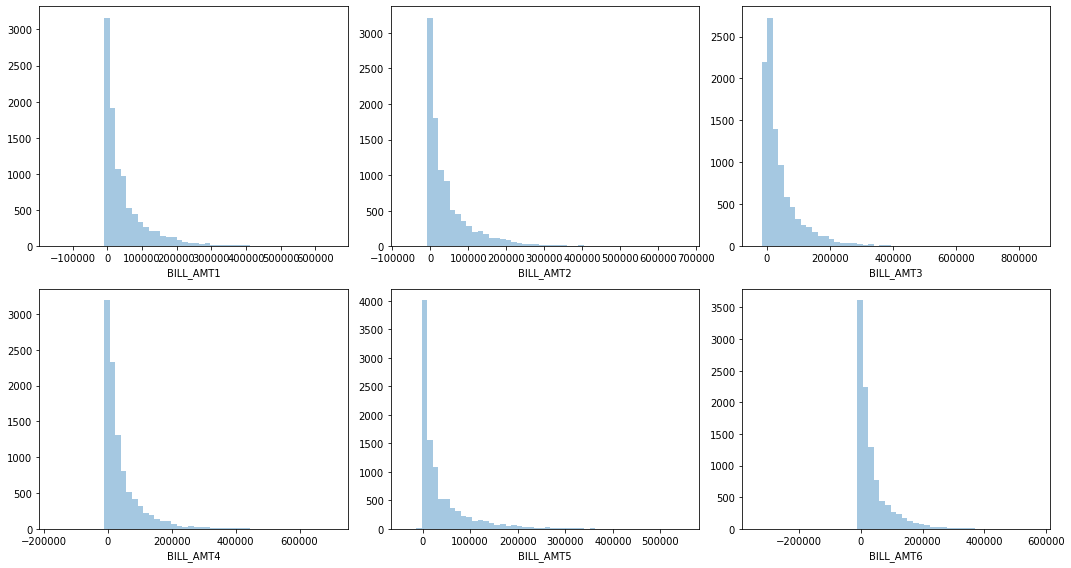

In [36]:
def monthly_plot(df, element):
    fig,axes = plt.subplots(2,3,figsize=(15,8))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        plt.subplot(ax)
        sns.distplot(df[element+str(i+1)], kde=False, ax=ax)
        ax.set(xlabel=element+str(i+1))
    
    plt.tight_layout()

monthly_plot(df_explore, 'BILL_AMT')



I found out that there are some negative billing payments, which shouldn't exist. I am going to remove them. 

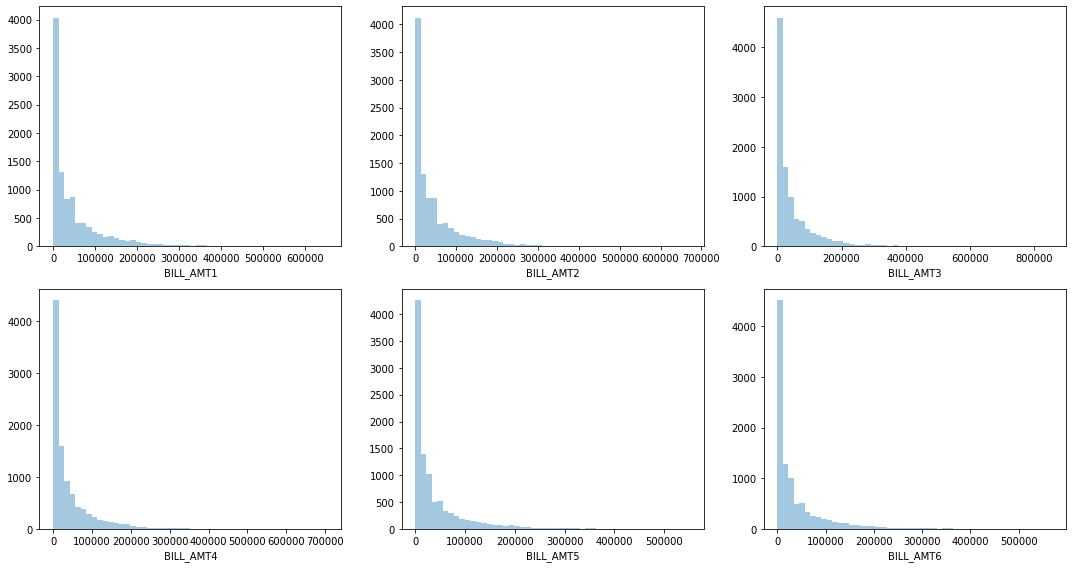

In [37]:
select_cols = ['BILL_AMT'+str(i) for i in range(1,7)]
df_explore[select_cols] = df_explore[select_cols].clip(lower=0)

monthly_plot(df_explore, 'BILL_AMT')


---
### Amount of previous payment: PAY_AMT(n)

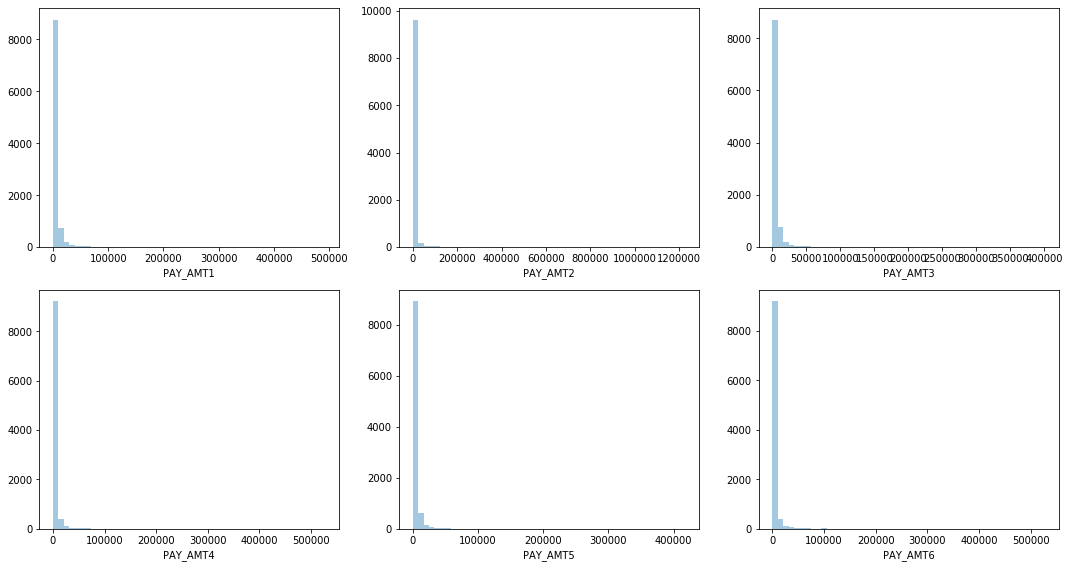

In [38]:
monthly_plot(df_explore, 'PAY_AMT')



---
# 4. Perform feature engineering



---
### Repayment status frequency

In [51]:
select_cols = ['PAY_'+str(i) for i in range(1,7)]
df_explore['N_PAY_DULY'] = df_explore[df_explore[select_cols]=='pay_duly'].count(axis=1)
df_explore['N_DELAYED'] = df_explore[df_explore[select_cols]=='delayed'].count(axis=1)
df_explore['N_UNKNOWN'] = df_explore[df_explore[select_cols]=='unknown'].count(axis=1)



In [52]:
d_rate_by_col(df_explore, 'N_PAY_DULY')


DEFAULT_PAY,0,1,perc
N_PAY_DULY,,,
0,4911,1680,0.254893
1,607,128,0.174150
2,500,94,0.158249
3,354,79,0.182448
4,407,79,0.162551
5,395,84,0.175365
6,588,94,0.137830


In [53]:
d_rate_by_col(df_explore, 'N_DELAYED')


DEFAULT_PAY,0,1,perc
N_DELAYED,,,
0,5883,808,0.120759
1,1006,473,0.319811
2,378,253,0.400951
3,185,188,0.504021
4,138,165,0.544554
5,39,58,0.597938
6,133,293,0.687793


In [54]:
d_rate_by_col(df_explore, 'N_UNKNOWN')

DEFAULT_PAY,0,1,perc
N_UNKNOWN,,,
0,901,461,0.338473
1,457,139,0.233221
2,534,240,0.310078
3,520,253,0.327296
4,660,272,0.291845
5,955,380,0.284644
6,3735,493,0.116604


N_DELAYED seems to be quite good at flagging default user. The higher the number of months, the higher the default rate.


---
### Credit utilisation rate


In [57]:
for i in range(1,7):
    df_explore['UTILIZE_PTG'+str(i)] = df_explore['BILL_AMT'+str(i)] / df_explore['LIMIT_BAL']


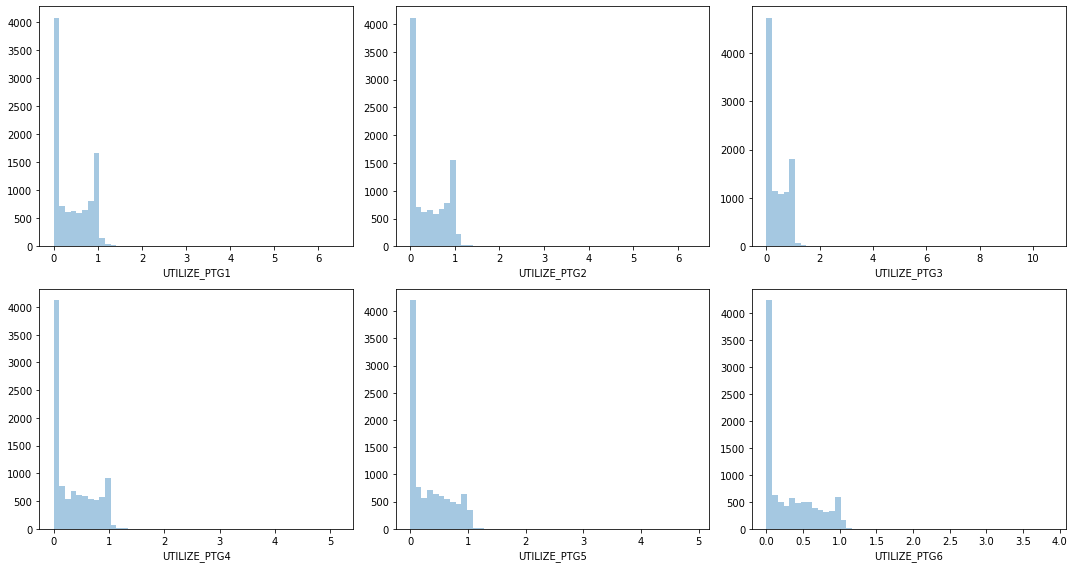

In [59]:
monthly_plot(df_explore, 'UTILIZE_PTG')


---

### Payment rate
Note that PAY_AMT(n) is related to BILL_AMT(n+1).

In [101]:
for i in range(1,6):
    df_explore['PAY_PTG'+str(i+1)] = ((df_explore['PAY_AMT'+str(i)]+0.01) / (df_explore['BILL_AMT'+str(i+1)]+0.01)).clip(upper=1)

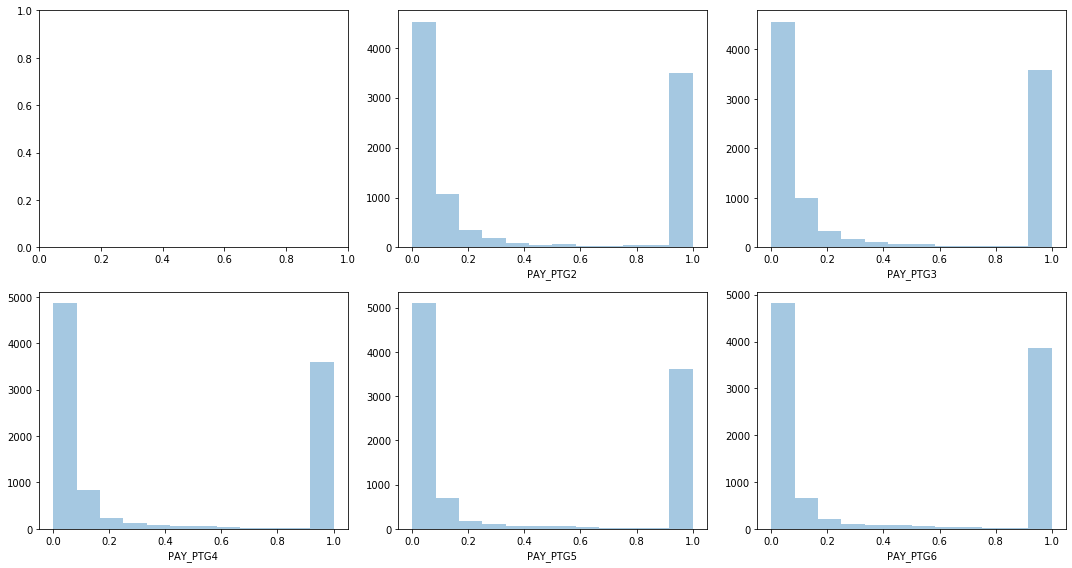

In [102]:
fig,axes = plt.subplots(2,3,figsize=(15,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i in range(1,6):
        plt.subplot(ax)
        sns.distplot(df_explore['PAY_PTG'+str(i+1)], kde=False, ax=ax)
        ax.set(xlabel='PAY_PTG'+str(i+1))

plt.tight_layout()

---

## One-hot Encoding for categorical data


In [105]:
onehot_names = ['SEX','EDUCATION','MARRIAGE']+['PAY_'+str(i) for i in range(1,7)]
onehot_names

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [106]:
df_onehot = pd.get_dummies(df_explore,columns=onehot_names)
df_onehot

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_3_unknown,PAY_4_delayed,PAY_4_pay_duly,PAY_4_unknown,PAY_5_delayed,PAY_5_pay_duly,PAY_5_unknown,PAY_6_delayed,PAY_6_pay_duly,PAY_6_unknown
0,1,50000.0,23,50653.0,49348.0,47995.0,40226.0,27828.0,28411.0,2190.0,...,1,0,0,1,0,0,1,0,0,1
1,2,10000.0,25,8525.0,5141.0,5239.0,7911.0,17890.0,10000.0,1500.0,...,1,0,0,1,0,0,1,0,1,0
2,3,150000.0,52,88812.0,90649.0,92499.0,94364.0,97589.0,99921.0,2564.0,...,1,0,0,1,0,0,1,0,0,1
3,4,280000.0,26,25989.0,27052.0,28111.0,29138.0,29852.0,30717.0,1800.0,...,1,0,0,1,0,0,1,0,0,1
4,5,360000.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,130000.0,34,23292.0,14077.0,15546.0,108047.0,93708.0,97353.0,3000.0,...,1,0,0,1,0,0,1,0,0,1
9996,9997,100000.0,35,3515.0,2975.0,2342.0,12016.0,10203.0,5323.0,10.0,...,0,0,1,0,0,0,1,0,0,1
9997,9998,280000.0,30,166037.0,166291.0,162992.0,134154.0,161057.0,167490.0,12126.0,...,1,0,0,1,0,0,1,0,0,1
9998,9999,170000.0,27,173577.0,171480.0,171794.0,166637.0,169021.0,164531.0,6500.0,...,1,0,0,1,0,0,1,0,0,1


In [107]:
df_onehot.columns.values

array(['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT_PAY',
       'N_PAY_DULY', 'N_DELAYED', 'N_UNKNOWN', 'UTILIZE_PTG1',
       'UTILIZE_PTG2', 'UTILIZE_PTG3', 'UTILIZE_PTG4', 'UTILIZE_PTG5',
       'UTILIZE_PTG6', 'PAY_PTG2', 'PAY_PTG3', 'PAY_PTG4', 'PAY_PTG5',
       'PAY_PTG6', 'SEX_female', 'SEX_male', 'EDUCATION_graduate_school',
       'EDUCATION_high_school', 'EDUCATION_university',
       'EDUCATION_unknown_and_others', 'MARRIAGE_married',
       'MARRIAGE_single', 'MARRIAGE_unknown_and_others', 'PAY_1_delayed',
       'PAY_1_pay_duly', 'PAY_1_unknown', 'PAY_2_delayed',
       'PAY_2_pay_duly', 'PAY_2_unknown', 'PAY_3_delayed',
       'PAY_3_pay_duly', 'PAY_3_unknown', 'PAY_4_delayed',
       'PAY_4_pay_duly', 'PAY_4_unknown', 'PAY_5_delayed',
       'PAY_5_pay_duly', 'PAY_5_unknown', 'PAY_6_delayed',
       'PAY_6_pay_duly', 

---

# 5. Quick fit and select the strongest predictors

---

## Transformation

In [234]:
feature_names = df_onehot.columns.values
feature_names = np.concatenate((feature_names[1:15], feature_names[17:]))
feature_names

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'N_DELAYED',
       'N_UNKNOWN', 'UTILIZE_PTG1', 'UTILIZE_PTG2', 'UTILIZE_PTG3',
       'UTILIZE_PTG4', 'UTILIZE_PTG5', 'UTILIZE_PTG6', 'PAY_PTG2',
       'PAY_PTG3', 'PAY_PTG4', 'PAY_PTG5', 'PAY_PTG6', 'SEX_female',
       'SEX_male', 'EDUCATION_graduate_school', 'EDUCATION_high_school',
       'EDUCATION_university', 'EDUCATION_unknown_and_others',
       'MARRIAGE_married', 'MARRIAGE_single',
       'MARRIAGE_unknown_and_others', 'PAY_1_delayed', 'PAY_1_pay_duly',
       'PAY_1_unknown', 'PAY_2_delayed', 'PAY_2_pay_duly',
       'PAY_2_unknown', 'PAY_3_delayed', 'PAY_3_pay_duly',
       'PAY_3_unknown', 'PAY_4_delayed', 'PAY_4_pay_duly',
       'PAY_4_unknown', 'PAY_5_delayed', 'PAY_5_pay_duly',
       'PAY_5_unknown', 'PAY_6_delayed', 'PAY_6_pay_duly',
       'PAY_6_unknown'], dtype=object)

In [235]:
continuous_names = feature_names[:27]
continuous_names

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'N_DELAYED',
       'N_UNKNOWN', 'UTILIZE_PTG1', 'UTILIZE_PTG2', 'UTILIZE_PTG3',
       'UTILIZE_PTG4', 'UTILIZE_PTG5', 'UTILIZE_PTG6', 'PAY_PTG2',
       'PAY_PTG3', 'PAY_PTG4', 'PAY_PTG5', 'PAY_PTG6'], dtype=object)

In [236]:
categorical_names = feature_names[28:]
categorical_names

array(['SEX_male', 'EDUCATION_graduate_school', 'EDUCATION_high_school',
       'EDUCATION_university', 'EDUCATION_unknown_and_others',
       'MARRIAGE_married', 'MARRIAGE_single',
       'MARRIAGE_unknown_and_others', 'PAY_1_delayed', 'PAY_1_pay_duly',
       'PAY_1_unknown', 'PAY_2_delayed', 'PAY_2_pay_duly',
       'PAY_2_unknown', 'PAY_3_delayed', 'PAY_3_pay_duly',
       'PAY_3_unknown', 'PAY_4_delayed', 'PAY_4_pay_duly',
       'PAY_4_unknown', 'PAY_5_delayed', 'PAY_5_pay_duly',
       'PAY_5_unknown', 'PAY_6_delayed', 'PAY_6_pay_duly',
       'PAY_6_unknown'], dtype=object)

In [237]:
# if I were to try SVM, remember to scale continuous variables before proceeding
feature_names = np.concatenate((continuous_names, categorical_names))

---
### Split into training and testing set

In [238]:
from sklearn.model_selection import train_test_split

# split the data
df_train,df_test = train_test_split(df_onehot,test_size=0.2,random_state=2020)

In [239]:
# Check training data
d_rate = df_train.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,6211,0.776375
1,1,1789,0.223625


In [240]:
# Check testing data
d_rate = df_test.groupby(['DEFAULT_PAY']).size().reset_index(name='N_USERS')
d_rate['PTG'] = d_rate['N_USERS']/sum(d_rate['N_USERS'])
d_rate

,DEFAULT_PAY,N_USERS,PTG
0,0,1551,0.7755
1,1,449,0.2245


---
### Try to fit on Random Forest

In [241]:
# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

In [242]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=50, random_state=0)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")


# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.9991608391608392
F1 testing score: 0.44692737430167595
Training time: 0.823 s
Prediction time: 0.016 s
Accuracy training score: 0.999625
Accuracy testing score: 0.802


Over fitting!!! Training score is really well but testing score is bad.

In [243]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=0,shuffle=True)

fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    feats = training[features] #defined above
    label = training['def_pay']
    valid_feats = valid[features]
    valid_label = valid['def_pay']
    classifier.fit(feats,label) #it is the last one we run, the best one
    pred = classifier.predict(valid_feats)
    score = accuracy_score(y_true = valid_label, y_pred = pred)
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})
# let's see what we have with ggplot
g = ggplot(performance,aes(x='Fold',y='Score')) + geom_point() + geom_line()
print(g)

NameError: name 'features' is not defined

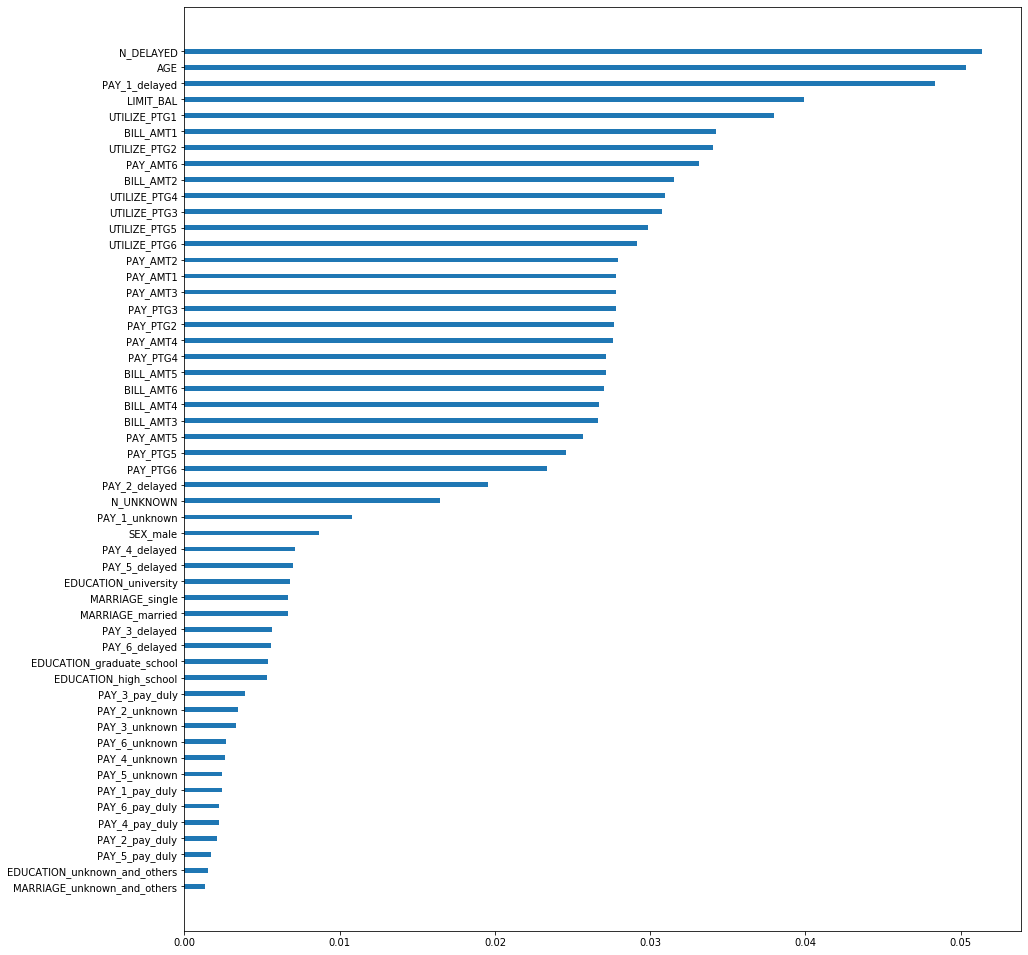

In [244]:
importances = clf.feature_importances_
importances

# visualize variable importance
importances = clf.feature_importances_
importances_sorted = np.argsort(importances) # sort in increasing order

plt.figure(figsize=(15,17))
plt.barh(range(importances.shape[0]), importances[importances_sorted], tick_label=feature_names[importances_sorted], height=0.3)
plt.show()


---
### PAY(n) delayed

In [245]:
feature_names =[
        'PAY_1_delayed',
        'PAY_2_delayed', 
        'PAY_3_delayed', 
        'PAY_4_delayed', 
        'PAY_5_delayed', 
        'PAY_6_delayed'
        ]

# get feature and labels
features_train, features_test = \
    df_train[feature_names].values, df_test[feature_names].values
labels_train, labels_test = \
    df_train['DEFAULT_PAY'].values,df_test['DEFAULT_PAY'].values

In [246]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=50, random_state=0)

# Train the model using the training sets
t0 = time()
clf.fit(features_train, labels_train)
training_time = round(time() - t0, 3)

# Predict the response for test dataset
t0 = time()
predictions = clf.predict(features_test)
prediction_time = round(time() - t0, 3)

# evaluate result
training_score = f1_score(y_true = labels_train, y_pred = clf.predict(features_train))
score = f1_score(y_true = labels_test, y_pred = predictions)

# Print results
print ("F1 training score:", training_score)
print ("F1 testing score:", score)
print ("Training time:", training_time, "s")
print ("Prediction time:", prediction_time, "s")


# quickly check the accuracy score as well
print ("Accuracy training score:", metrics.accuracy_score(labels_train, clf.predict(features_train)))
print ("Accuracy testing score:", metrics.accuracy_score(labels_test, predictions))

F1 training score: 0.4173913043478261
F1 testing score: 0.3880597014925373
Training time: 0.12 s
Prediction time: 0.009 s
Accuracy training score: 0.807375
Accuracy testing score: 0.795


In [253]:
importances = clf.feature_importances_
importances

# visualize variable importance
importances = clf.feature_importances_
importances_sorted = np.argsort(importances) # sort in increasing order

range(importances.shape[0])

range(0, 6)

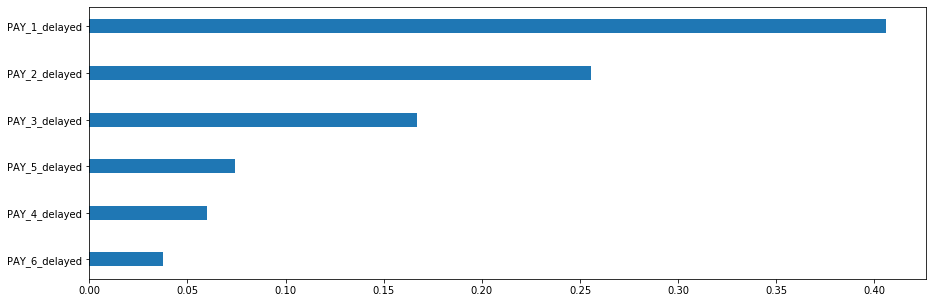

In [264]:
plt.figure(figsize=(15,5))
plt.barh(range(importances.shape[0]), importances[importances_sorted], tick_label=np.array(feature_names)[importances_sorted.astype(int)], height=0.3)
plt.show()


In [262]:
feature_names[importances_sorted]

TypeError: only integer scalar arrays can be converted to a scalar index

In [261]:
importances_sorted.astype(int)

array([5, 3, 4, 2, 1, 0])

In [263]:
np.array(feature_names)[importances_sorted.astype(int)]

array(['PAY_6_delayed', 'PAY_4_delayed', 'PAY_5_delayed', 'PAY_3_delayed',
       'PAY_2_delayed', 'PAY_1_delayed'], dtype='<U13')